# Your First Machine Learning Model - K-means Clustering (Part 2)

In this notebook, we'll be using k-means clustering to examine accelerometer exceptions data. There are a variety of reasons you might want to do this. One suggested goal is to create targeted safety programs for drivers to improve overall fleet safety and reduce the incidence of harsh driving  - and ultimately accidents. If you aren't familiar with k-means clustering, go through at least the introduction of the Part 1 notebook before proceeding. 

A typical way that you might assess drivers is through creating a risk management report in MyGeotab. You could choose the exceptions of interest and generate a report split up by driver, summarizing their behaviour over the last few weeks or months. You can compare drivers and identify those who may be in need of safety intervention.

![risk report](https://raw.githubusercontent.com/nanodan/images/master/risk_report.png)

This becomes difficult to scale as the number of drivers increases. What happens when we have 50 drivers? What about 500? How do we design these targeted safety programs and properly assign our drivers to the right program? How many programs do we need? What are the common patterns of driving behaviour present in our fleet? 

These types of questions can be answered using machine learning, with a variety of approaches; one of those approaches is k-means clustering. We can use k-means clustering to identify the types/groups of drivers (and simultaneously assign them) and subsequently design targeted safety programs based on the average characteristics of each of the identified groups.

Rather than assessing each driver individually, and attempting to determine - based on all their historical data - where the biggest problems are, then working one-by-one to address these problems, we can instead design a smaller set of interventions that will be broadly applicable to each group with common patterns of driving behaviour.


# Data Ingestion

In [1]:
#@title Imports
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import branca.colormap
import branca.utilities

from google.colab import auth
from google.cloud import bigquery

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

%matplotlib inline

 In order to access the data, please run the authentication cell, follow the link,  and copy the code that you receive into the box, then press enter before proceeding with the rest of the notebook.

In [2]:
#@title Authenticate
_ = auth.authenticate_user()

In [3]:
#@title Client credentials
client = bigquery.Client(project='geotab-bootcamp')

In [4]:
#@title SQL query to pull data from BigQuery
SQL = """
select DriverId, TripNumber, TripType, Loaded
     , cast(Distance as int64)             as Distance
     , NumberOfBrakingEvents               as NumBrakingEvents
     , NumberOfCorneringEvents             as NumCorneringEvents
     , NumberOfAccelerationEvents          as NumAccelEvents
     , cast(AvgBrakingSpeed as int64)      as AvgBrakingSpeed
     , cast(AvgCorneringSpeed as int64)    as AvgCorneringSpeed
     , cast(AvgAccelerationSpeed as int64) as AvgAccelSpeed
     , round(AvgBrakingMagnitude, 2)       as AvgBrakingMagnitude
     , round(AvgCorneringMagnitude, 2)     as AvgCorneringMagnitude
     , round(AvgAccelerationMagnitude, 2)  as AvgAccelMagnitude
  from `geotab-bootcamp.DemoData.HarshDriving`
"""

In [5]:
#@title Run the query
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False
df = client.query(SQL, job_config=job_config).to_dataframe()

Using the query above, we've pulled in all of the recent trip data from our drivers. Each row includes summary data for an individual trip and includes:
* the number of harsh events by category,
* the average speed and magnitude of all harsh events by category,
* the total trip distance,
* the type of trip,
* and whether the truck was loaded with cargo or empty.

In [6]:
df.head(2)

,DriverId,TripNumber,TripType,Loaded,Distance,NumBrakingEvents,NumCorneringEvents,NumAccelEvents,AvgBrakingSpeed,AvgCorneringSpeed,AvgAccelSpeed,AvgBrakingMagnitude,AvgCorneringMagnitude,AvgAccelMagnitude
0,0,78,Urban,Unloaded,129,31,32,30,31.0,21.0,25.0,9.56,13.67,9.82
1,0,19,Suburban,Unloaded,128,35,31,31,15.0,31.0,44.0,3.52,11.92,5.28


In [7]:
print('Number of trips:', df.shape[0])
print('Number of drivers:', df['DriverId'].unique().shape[0])

Number of trips: 15895
Number of drivers: 103


# First Visualization

We have a total of 15,895 trips from 103 different drivers. Definitely too many for us to easily assess them all individually in a manual process! Let's take a look at one of the possible column pairs; "distance" and "number of braking events".

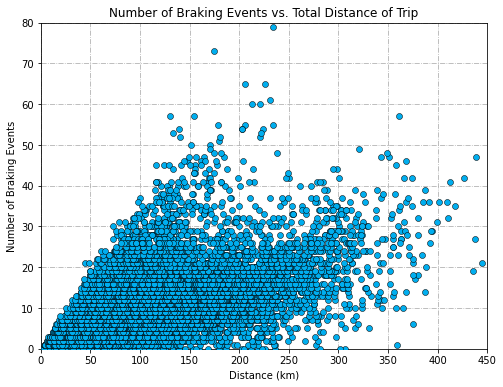

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
_ = ax.scatter(df['Distance'], df['NumBrakingEvents'], c='#00aeef', edgecolors='black', linewidths=0.5, zorder=3)
_ = ax.grid(linestyle='-.', zorder=0)
_ = ax.set_xlabel('Distance (km)')
_ = ax.set_ylabel('Number of Braking Events')
_ = ax.set_title('Number of Braking Events vs. Total Distance of Trip')
_ = ax.set_xlim([0, 450])
_ = ax.set_ylim([0, 80])

Do you see any interesting patterns there? Can you hypothesize why these patterns might be occuring? Is there a column you could use in the table to try and understand some of these patterns better?

When ready, expand the next section to see how I would approach this.

# Data Exploration

We can see in our dataframe that we have a couple of categorical variables that might shed some light onto the patterns we saw in our braking event data. One of them is type of trip. Let's take a look at the same braking data, but split it up by trip type.

In [9]:
print(df['TripType'].value_counts())

Urban       5182
Highway     4185
Suburban    3727
Rural       2801
Name: TripType, dtype: int64


We've got four trip types in this data, dominated by "Urban" and "Highway" driving. Let's look at these four trip types and see if the relationship between distance and number of braking events changes.

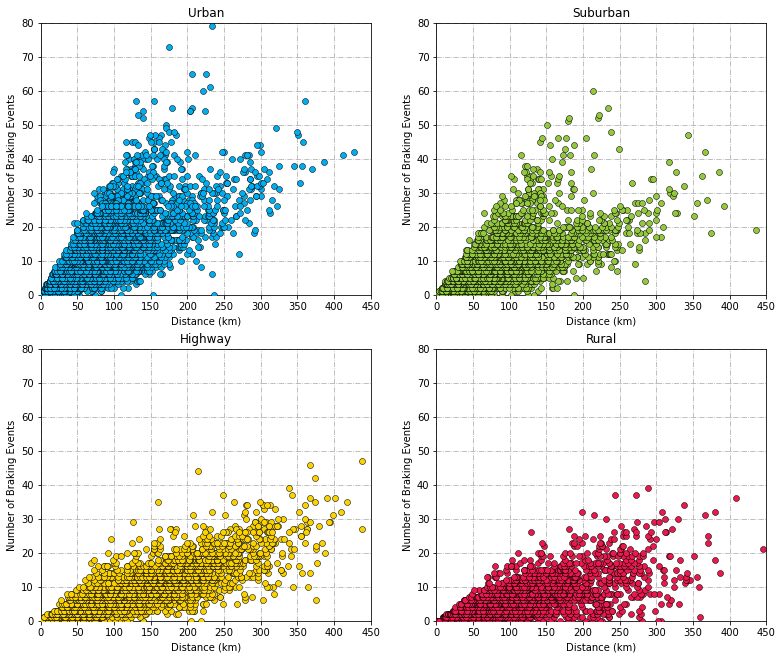

In [10]:
fig = plt.figure(figsize=(13, 11), constrained_layout=False)
axes = []
for i in range(4):
    axes.append(fig.add_subplot(221+i))
    
colors = ['#00aeef', '#93c83d', '#fad201', '#ea184d']

for i, trip in enumerate(df['TripType'].unique()):
    dftemp = df[df['TripType'] == trip]
    _ = axes[i].scatter(dftemp['Distance'], dftemp['NumBrakingEvents'], c=colors[i], edgecolors='black', linewidths=0.5, label=trip, zorder=3)
    _ = axes[i].set_title(trip)
    _ = axes[i].set_xlim([0, 450])
    _ = axes[i].set_ylim([0, 80])
    _ = axes[i].set_xlabel('Distance (km)')
    _ = axes[i].set_ylabel('Number of Braking Events')
    _ = axes[i].grid(linestyle='-.', zorder=0)

Interesting! What types of patterns do you notice now? Can you already start to draw some conclusions about your drivers and the type of trips they make?

Are there other relationships that you want to plot? We have a lot of columns in this dataframe and we don't necessarily want to keep making these plots for every pair. With 10 numeric columns, we have 45 possible pairs. Luckily there is a function in seaborn called pairplot we can use to plot all of these pairs at once. Let's do that below for a subset of the columns and see what kind of relationships there are. 

Go ahead and add other columns that you're interested in comparing.

(Depending on the environment you run this notebook in, the function may take a minute or two to render all the plots)

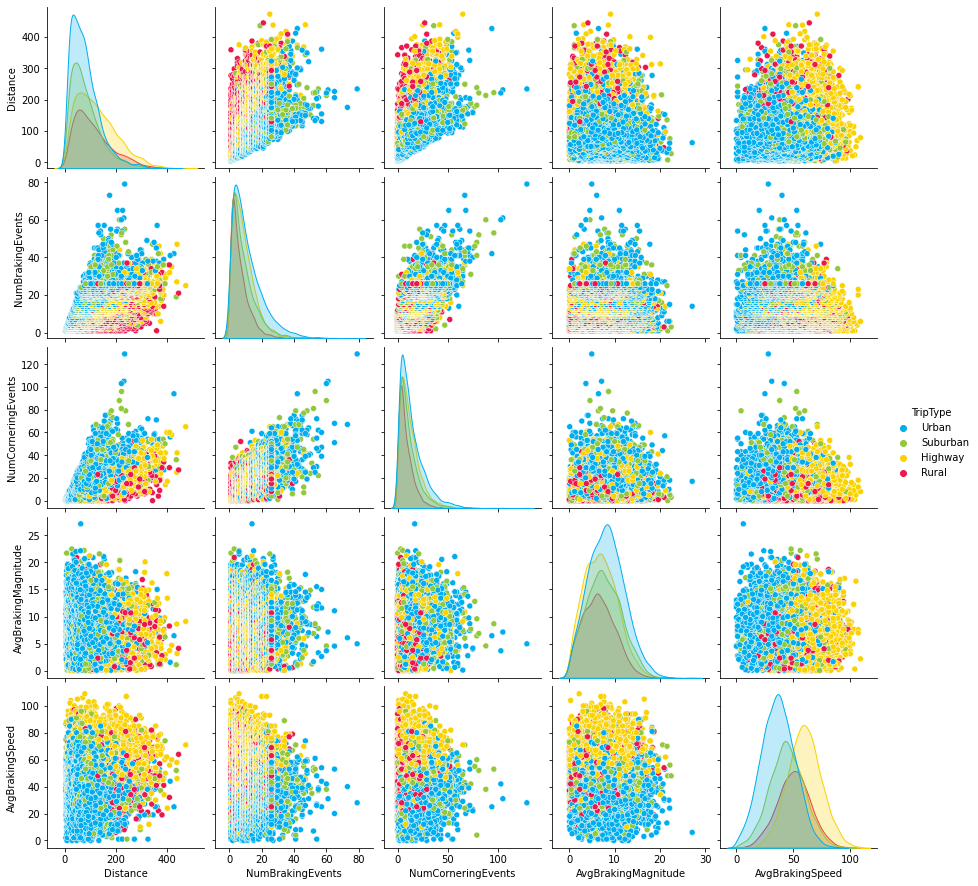

In [11]:
sns.pairplot(df[['TripType', 'Distance', 'NumBrakingEvents', 'NumCorneringEvents', 'AvgBrakingMagnitude', 'AvgBrakingSpeed']].dropna(), 
             palette={'Urban': '#00aeef', 'Suburban': '#93c83d', 'Highway': '#fad201', 'Rural': '#ea184d'},
             hue='TripType')

Do you see any obvious relationships in the pair plots above? How would you proceed? Think back to our goal. When you're ready, expand the next section.

# Aggregation and Feature Engineering

We can see in the pair plots that there are some differences between trip types, and some relationships between the columns, but they don't seem to be very clear, or strong.

But let's think about what we're actually trying to do; we want to classify drivers, not trips. Let's generate some aggregated data for our drivers, instead of looking at the individual trips.

There are a lot of different ways we could perform this aggregation, and there is no "right" answer on how to do this. A common aggregation you'll want to perform is to find the mean (average) of a set of data. But you could easily extract other information such as:
* the median, 
* the 85th percentile, 
* the number of events greater than some threshold, 
* a ratio of values
* etc. 

What I'm describing here is called **feature engineering**, and can be as much an art as a science. To choose the right *features* for your model requires a good understanding of your data and business problem, and a strong intuition about the most relevant input data. In fact, much of the time that you'll spend when doing machine learning will go into feature engineering:

![time allocation](https://raw.githubusercontent.com/nanodan/images/master/ratio_of_time.png)

There are a variety of techniques for helping you to reduce and refine your feature space, but they're beyond the scope of this session. I encourage you to read more about feature engineering on your own. For now, feel free to explore and experiment with different features that you think may be relevant and see what the results are.

With that context in mind, lets proceed! We'll start by just taking the simple average of each column as our first try for a set of driver-aggregated features.

In [12]:
#@title Group by Driver
df_g = df.drop(columns=['TripNumber']).groupby(by=['DriverId']).mean()

In [13]:
df_g.head(2)

,Distance,NumBrakingEvents,NumCorneringEvents,NumAccelEvents,AvgBrakingSpeed,AvgCorneringSpeed,AvgAccelSpeed,AvgBrakingMagnitude,AvgCorneringMagnitude,AvgAccelMagnitude
DriverId,,,,,,,,,,
0,57.070064,9.121019,7.783439,7.414013,43.381944,27.986014,26.685315,8.961528,7.636084,7.261049
1,68.333333,11.296296,9.500000,8.067901,42.006410,26.026316,25.061644,9.278846,6.945987,6.691301


Let's take a quick look at the histogram for our average trip distances.

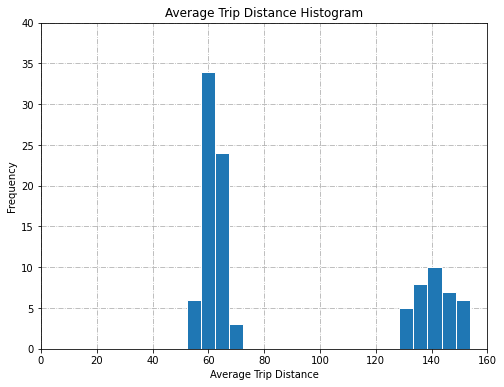

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
_ = ax.hist(df_g['Distance'], bins=20, edgecolor='white', density=False, zorder=3)
_ = ax.grid(linestyle='-.', zorder=0)
_ = ax.set_xlim([0, 160])
_ = ax.set_ylim([0, 40])
_ = ax.set_ylabel('Frequency')
_ = ax.set_xlabel('Average Trip Distance')
_ = ax.set_title('Average Trip Distance Histogram')

Looks like we have two distinct types of drivers, short trips and longer trips in two distinct clusters. That's a good start. What if we take another look at the number of braking events vs. distance like we were doing before.

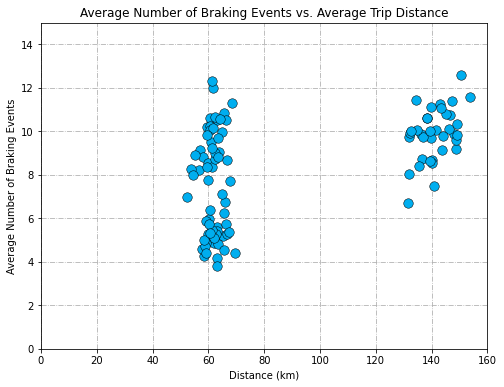

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

_ = ax.scatter(df_g['Distance'], df_g['NumBrakingEvents'], c='#00aeef', s=90, edgecolors='black', linewidths=0.5, zorder=3)
_ = ax.grid(linestyle='-.', zorder=0)
_ = ax.set_xlabel('Distance (km)')
_ = ax.set_ylabel('Average Number of Braking Events')
_ = ax.set_title('Average Number of Braking Events vs. Average Trip Distance')
_ = ax.set_xlim([0, 160])
_ = ax.set_ylim([0, 15])

Interesting! How many clusters do you see here? Looks like we're starting to see some distinct groupings of drivers. I've provided the code below to make a pairplot on our aggregated dataframe. Take a look and try adding some more columns. What kind of relationships do you see? Do you think this problem is amenable to clustering? How many clusters do you want to try?


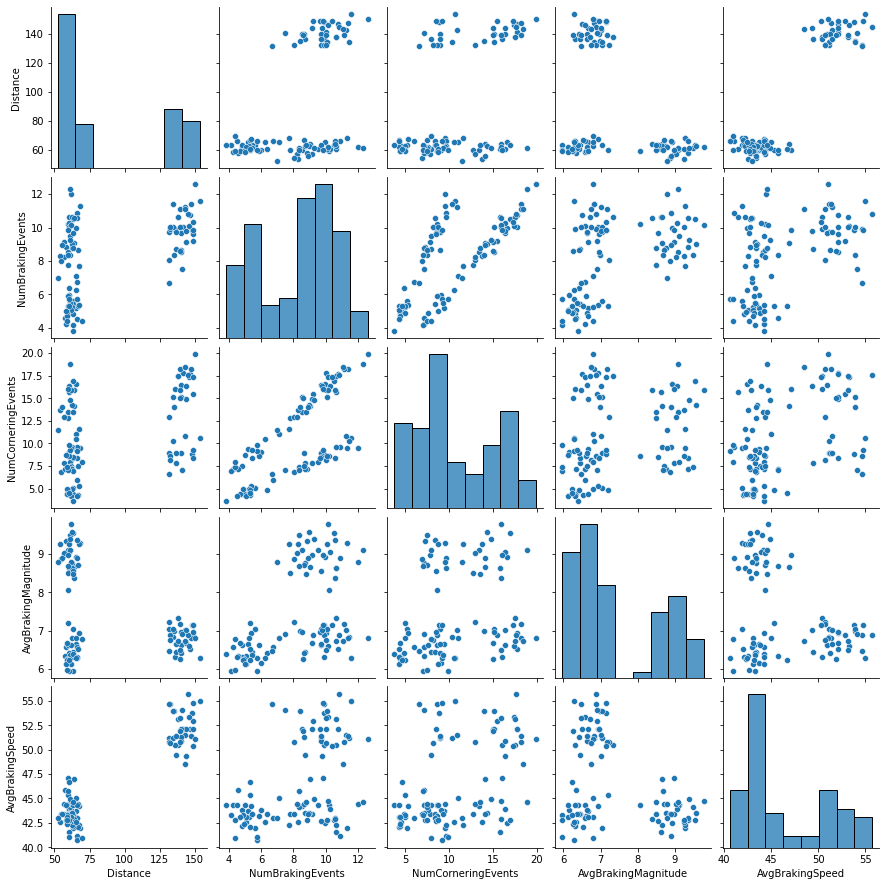

In [16]:
sns.pairplot(df_g[['Distance', 'NumBrakingEvents', 'NumCorneringEvents', 'AvgBrakingMagnitude', 'AvgBrakingSpeed']].dropna())

Let's just try clustering distance and number of braking events to start with, and see what happens. We'll start with three clusters.


In [17]:
X = df_g[['Distance', 'NumBrakingEvents']]
kmn = KMeans(n_clusters=3, n_jobs=-1)
_ = kmn.fit(X)

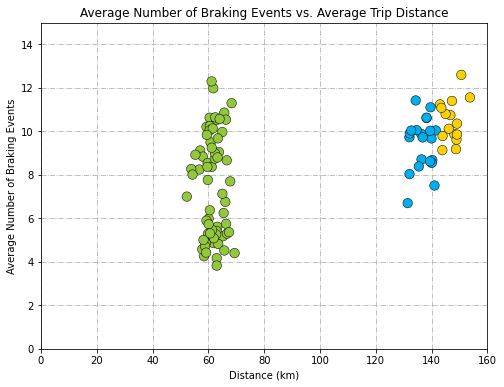

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

_ = ax.scatter(df_g['Distance'], df_g['NumBrakingEvents'], c=[colors[i] for i in kmn.labels_], s=90, edgecolors='black', linewidths=0.5, zorder=3)
_ = ax.grid(linestyle='-.', zorder=0)
_ = ax.set_xlabel('Distance (km)')
_ = ax.set_ylabel('Average Number of Braking Events')
_ = ax.set_title('Average Number of Braking Events vs. Average Trip Distance')
_ = ax.set_xlim([0, 160])
_ = ax.set_ylim([0, 15])

Woah, what's going on? K-means seems to have identified the wrong clusters. It looks like we should have two clusters on the left there, and one on the right, so what is happening?

Think back to the assumptions that are built into k-means clustering. 
* Each cluster is roughly isotropic (i.e. spherical variance)
* All clusters are similar in "spatial" extent (i.e. similar variance along each dimension to every other cluster)
* The prior probability of each cluster is the same (i.e. a similar number of observations exist in each cluster)

Look carefully at the plot and think about which assumption we are violating the most and why this is a problem. Once you think you have the answer, expand the next section to see if you're right.


## Fixing Violated Assumptions

If you noticed that our clusters are not isotropic, well done! The problem here is that we are trying to cluster data points with two dimensions that have very different scales. Our distance dimension ranges from $\sim50 - 160$ km while our average number of braking events ranges from $\sim 4 - 13$ per trip. Without doing any variance calculations we can already tell that we're not going to have spherical variance here.

That doesn't mean we have to give up on clustering though! We just have to scale our features so that we no longer violate the assumptions of k-means. When we are clustering here, we're not actually interested in the absolute values of our features; we may be interested in them after clustering, to find things like the average number of events in each cluster, but it's not actually important in clustering itself. What is important is the relationship between the features. 

The solution then is to scale every feature so that they have the same variance.

In [19]:
X_scaled = scale(X)

Let's plot the data again, and see what changed.

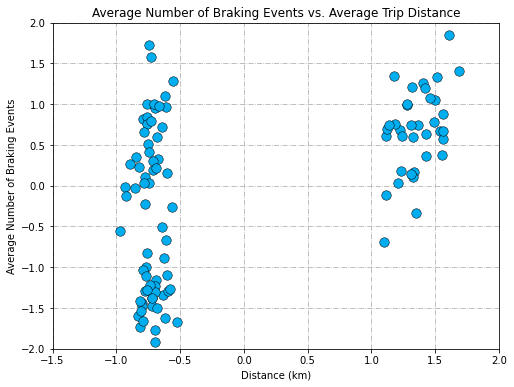

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

_ = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=colors[0], s=90, edgecolors='black', linewidths=0.5, zorder=3)
_ = ax.grid(linestyle='-.', zorder=0)
_ = ax.set_xlabel('Distance (km)')
_ = ax.set_ylabel('Average Number of Braking Events')
_ = ax.set_title('Average Number of Braking Events vs. Average Trip Distance')
_ = ax.set_xlim([-1.5, 2])
_ = ax.set_ylim([-2, 2])

# First Clustering

You can see our two features here now have similar variance, but the overal cluster shape and data relationship hasn't changed. Let's try clustering again and see what happens this time, when we're no longer violating the k-means assumptions.

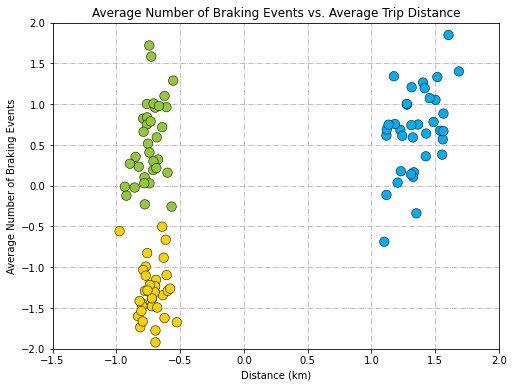

In [21]:
kmn = KMeans(n_clusters=3, n_jobs=-1)
_ = kmn.fit(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

_ = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=[colors[i] for i in kmn.labels_], s=90, edgecolors='black', linewidths=0.5, zorder=3)
_ = ax.grid(linestyle='-.', zorder=0)
_ = ax.set_xlabel('Distance (km)')
_ = ax.set_ylabel('Average Number of Braking Events')
_ = ax.set_title('Average Number of Braking Events vs. Average Trip Distance')
_ = ax.set_xlim([-1.5, 2])
_ = ax.set_ylim([-2, 2])

Much better! You can see the importance of **always** checking your *assumptions*.

Let's add the k-means labels as a column in a temporary dataframe here and we'll re-draw those pair-plots.

In [22]:
def turn_to_letter(row):
    return string.ascii_uppercase[int(row['Group'])]

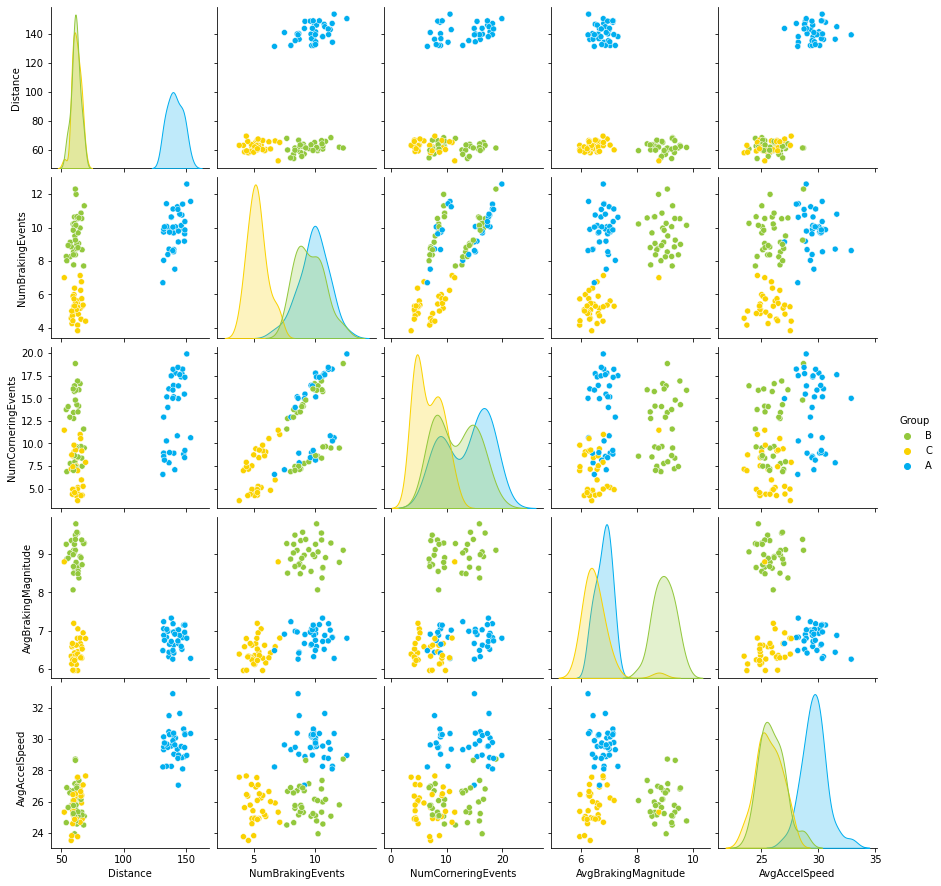

In [23]:
dftemp = df_g.copy()
dftemp['Group'] = kmn.labels_
dftemp['Group'] = dftemp.apply(turn_to_letter, axis=1)

sns.pairplot(dftemp[['Group', 'Distance', 'NumBrakingEvents', 'NumCorneringEvents', 'AvgBrakingMagnitude', 'AvgAccelSpeed']].dropna(), 
             palette={'A': '#00aeef', 'B': '#93c83d', 'C': '#fad201'},
             hue='Group')

You can probably tell that we've started to identify some of the clusters in our data, but it's not perfect yet. We've got some overlapping clusters, and cases where there are clearly more than 3 clusters, as well as some "stretched" data that's violating k-means assumptions and would need to be corrected; so there's lots of room to improve yet. I haven't displayed all of our features either. Below is a quick summary table grouped by cluster. What kind of patterns are you noticing so far? Would this help inform a safety training plan?

In [24]:
df_cg = dftemp.groupby(by='Group').mean()
print(df_cg)

         Distance  NumBrakingEvents  ...  AvgCorneringMagnitude  AvgAccelMagnitude
Group                                ...                                          
A      141.125674          9.872025  ...               5.638860           5.585555
B       61.383194          9.547546  ...               6.955341           7.094242
C       62.018265          5.291363  ...               5.449302           5.535504

[3 rows x 10 columns]


The examples so far use only two dimensions for ease of visualization, but k-means can work with any number of dimensions. An important thing to know however, is that as you keep increasing the number of dimensions you start to run into the "curse of dimensionality". The "volume" of a euclidean space rapidly increases with the number of dimensions and you need an increasingly large data sample to fill it.

Imagine a 1-D grid of 5 spaces. Let's say we "fill" it with 5 data points. If we add a dimension to get a 2D 5x5 grid, we now need 25 data points to have similar coverage. If we add another dimension, we now need 125 data points, and so on. 

Euclidean distances also start to explode in value.  In a high-dimensional space, the ratio of distances from nearest to furthest points start to approach one - unless you add more data samples - making the algorithm useless. In these cases you can use dimensionality reduction techniques prior to clustering, acquire more data, or think about how to reduce the scope of the problem.

# Try Your Own Clustering

With the above points in mind, start trying out different features for clustering. Try to cluster on *all* of our features. Whats the optimal number of clusters in that case? Try clustering only on trips above or below a certain distance. What about outliers?

You can use the code provided thus far as a template to get you started. Remember that it's going to become hard to visualize your clusters once you start adding more dimensions so utilize things like pairplots and aggregate values to get a sense of your clusters.

Do you want to generate new features? Let's pull back a dataframe already grouped by DriverId with those averages we were looking at. This will give you a starting point to add in new features that you think of. I've added a few to get you started.

In [25]:
SQL = """
select DriverId
     , avg(Distance) as Distance
     , avg(ifnull(NumberOfBrakingEvents, 0)/Distance) as BrakingEventDistanceRatio
     , avg(NumberOfBrakingEvents) as AvgNumberOfBrakingEvents
  from `geotab-bootcamp.DemoData.HarshDriving`
 group by DriverId
"""

In [26]:
#@title Run the query
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False
df = client.query(SQL, job_config=job_config).to_dataframe()